In [88]:
from collections import defaultdict
import numpy as np
import json
import networkx as nx
from matplotlib import pyplot as plt
from pyvis.network import Network
import pandas as pd

In [89]:
items = open("items.txt").readlines()
items = [s.replace("\n","") for s in items]
mods = np.unique([s.split(":")[0] for s in items])
print(mods)

['amendments' 'arcane_abilities' 'artifacts' 'backpacked'
 'betterarcheology' 'chimes' 'comforts' 'create' 'createoreexcavation'
 'exposure' 'exposure_polaroid' 'l2artifacts' 'lootr' 'mcwpaths'
 'minecraft' 'moa_art' 'moonlight' 'naturescompass' 'palegarden'
 'patchouli' 'protection_pixel' 'rarcompat' 'relics' 'sereneseasons'
 'stonkstimecore' 'supplementaries' 'suppsquared' 'tiab'
 'travelerscompass' 'waterframes']


In [90]:
recipes = json.load(open("recipes.json"))
for r in recipes.keys():
    for ingr in list(recipes[r]["input"].keys()):
        new = ingr.replace("net.minecraft.world.item.crafting.","")
        recipes[r]["input"][new] = recipes[r]["input"].pop(ingr)

        if new == "Ingredient@1":
            recipes[r]["input"].pop(new)
display(recipes)

{'mcwpaths:dark_prismarine_dumble_paving': {'output': {'mcwpaths:dark_prismarine_dumble_paving': 4},
  'input': {'Ingredient@a6c8975': {'minecraft:dark_prismarine': 1}},
  'type': 'stonecutting'},
 'minecraft:andesite_wall': {'output': {'minecraft:andesite_wall': 6},
  'input': {'Ingredient@2ac38381': {'minecraft:andesite': 6}},
  'type': 'crafting'},
 'protection_pixel:jetloot': {'output': {'protection_pixel:heatpulsethruster': 1},
  'input': {'Ingredient@2435b984': {'create:chute': 4},
   'Ingredient@34f0725d': {'create:andesite_alloy': 3},
   'Ingredient@e8b4a891': {'create:precision_mechanism': 1},
   'Ingredient@62859c60': {'minecraft:iron_ingot': 2},
   'Ingredient@339ca530': {'create:mechanical_pump': 2},
   'Ingredient@21746ddd': {'create:fluid_tank': 1}},
  'type': 'create:mechanical_crafting'},
 'create:crafting/logistics/magenta_table_cloth_from_other_table_cloth': {'output': {'create:magenta_table_cloth': 1},
  'input': {'Ingredient@712469c8': {'minecraft:magenta_dye': 1},


In [91]:
graph = nx.DiGraph()

# Item Node
graph.add_nodes_from(items, type="item", SCT=np.nan, color='#8ceef5', size=30, shape="dot")

for r in recipes.keys():
    # Recipe Node
    graph.add_node(f"{recipes[r]['type']}-{r}", type="craft", SCT=np.nan, color='green', size=15, shape="diamond")

    for ingr in recipes[r]["input"].keys():

        # Ingredient Node
        graph.add_node(ingr, type="ingredient", SCT=np.nan, color='orange', size=5, shape="square")

        inputs = list(recipes[r]["input"][ingr].keys())
        output = list(recipes[r]["output"])
        if len(output) == 0:
            print(f"No output for {r}")
            continue

        inAmount = list(recipes[r]["input"][ingr].values())
        outAmount = recipes[r]["output"][output[0]]

        # Item -> Ingredient (not necessarily unique)
        graph.add_edges_from([(i, ingr) for i in inputs])

        # Ingredient -> Recipe (amount is the same for every item in an ingredient)
        graph.add_edge(ingr,f"{recipes[r]['type']}-{r}", weight=inAmount[0])

        # Recipe -> Item
        graph.add_edge(f"{recipes[r]['type']}-{r}",output[0], weight=outAmount)

No output for create:mixing/lava_from_cobble
No output for create:mixing/chocolate_melting
No output for create:mixing/tea
No output for create:mixing/honey
No output for create:mixing/chocolate
No output for create:mixing/chocolate


# Plotting

In [5]:
def plotGraph(subgraph, name, ylim=1000, fixedInOut=True):
    g = Network(width=1900, height=1000, directed=True, select_menu=True)
    g.options.edges.smooth.enabled = False
    g.from_nx(subgraph.copy())

    top_y = -ylim  # Top line y-coordinate
    bottom_y = ylim  # Bottom line y-coordinate

    # Get source and sink nodes
    sources = [n for n in subgraph.nodes if subgraph.in_degree(n) == 0]
    sinks = [n for n in subgraph.nodes if subgraph.out_degree(n) == 0]

    i = 0
    j = 0
    d = 200
    for n in g.nodes:
        nid = n["id"]
        n["size"] = subgraph.nodes[nid].get("size", 30)
        n["color"] = subgraph.nodes[nid].get("color", "gray")
        n["shape"] = subgraph.nodes[nid].get("shape", "circle")
        n["font"] = {"size":10}

        if (nid in sources) & fixedInOut:
            n["x"] = d/2 * i + d/2 if i%2 == 1 else - d/2 * i
            n["y"] = bottom_y
            n["fixed"] = {"x": True, "y": True}
            n["physics"] = False
            n["color"] = "red"
            i += 1
        elif (nid in sinks) & fixedInOut:
            n["x"] = d/2 * j + d/2 if j%2 == 1 else - d/2 * j
            n["y"] = top_y
            n["fixed"] = {"x": True, "y": True}
            n["physics"] = False
            n["color"] = "red"
            j += 1


        elif fixedInOut:
            n["y"] = np.random.normal(0, ylim/5)
            n["physics"] = True
            n["fixed"] = {"x": False, "y": False}


    for e in g.edges:
        src, dst = e['from'], e['to']
        weight = subgraph[src][dst].get("weight", 0)
        if isinstance(weight, list):
            print(e, weight)
            weight = sum(weight)
        e['label'] = str(weight)
        e["font"] = {"size": 15, "color": "black"}
        e['arrows'] = 'to'
        e['arrowStrikethrough'] = False
        e['width'] = 1 + 2 * weight
        e['smooth'] = False

    g.barnes_hut(spring_strength=1, spring_length=1000, overlap=1)

    g.set_options("""
    {
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -50,
          "springLength": 200,
          "springConstant": 0.05
        },
        "maxVelocity": 20,
        "solver": "forceAtlas2Based",
        "timestep": 0.35,
        "stabilization": {
          "iterations": 150
        }
      }
    }
    """)


    g.show(f"{name}.html", notebook=False)

In [58]:
graphDirt = graph.subgraph(nx.descendants(graph,"minecraft:dirt") | {"minecraft:dirt"}).copy()
plotGraph(graphDirt, "graphDirt")

graphDirt.html


In [60]:
graphIron = graph.subgraph(nx.descendants(graph,"minecraft:iron_ingot") | {"minecraft:iron_ingot"}).copy()
plotGraph(graphIron, "graphIngot", ylim=10000)

graphIngot.html


In [57]:
graphLapis = graph.subgraph(nx.descendants(graph,"minecraft:lapis_ore") | {"minecraft:lapis_ore"}).copy()
plotGraph(graphLapis, "graphLapis", ylim=20000)

graphLapis.html


In [73]:
plotGraph(graph, "graphFull", ylim=50000)

graphFull.html


# Degree

592 911 1762


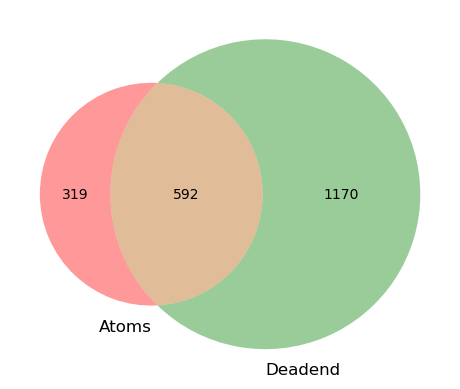

In [6]:
from matplotlib_venn import venn2, venn3
deadend = []
atoms = []

for n,data in list(graph.nodes(data=True)):
	if data["type"] != "item":
		continue

	if graph.in_degree(n) == 0:
		atoms.append(n)
	if graph.out_degree(n) == 0:
		deadend.append(n)

atoms = set(atoms)
deadend = set(deadend)
isolated = set.intersection(atoms, deadend)

print(len(isolated), len(atoms), len(deadend))

venn2((atoms, deadend), set_labels=("Atoms","Deadend"))
plt.show()

In [10]:
source = list(deadend - isolated)[40]
source = "minecraft:creeper_banner_pattern"
print(source)
graphAncestor = graph.subgraph(nx.ancestors(graph, source=source) | {source}).copy()
plotGraph(graphAncestor, "graphAncestors", ylim=300)

minecraft:creeper_banner_pattern
graphAncestors.html


# Back Propagation

In [9]:
def computeValue(g, node):
    print(f"Computing node {node}")
    t = g.nodes[node]["type"]

    predecessors = list(g.predecessors(node))
    print(f"Has predecessors {predecessors} {[g.nodes[p]['SCT'] for p in predecessors]}")
    hasBeenComputed = ~np.isnan([g.nodes[p]["SCT"] for p in predecessors])
    for hasBeen,p in zip(hasBeenComputed,predecessors):
        if hasBeen:
            continue
        computeValue(g, p)

    if t == "item":
        computeValueItem(g, node, predecessors)
    if t == "ingredient":
        computeValueIngredient(g, node, predecessors)
    if t == "craft":
        computeValueRecipe(g, node, predecessors)

def computeValueItem(g, node, predecessors):
    # Only Recipes nodes connect to an Item node
    # The logic is x = rk / ck
    g.nodes[node]["SCT"] = [g.nodes[p]["SCT"] / g[p][node].get("weight", np.nan) for p in predecessors]
    print(f"\t Item node {node} has values {g.nodes[node]['SCT']} -> {min(g.nodes[node]['SCT'])}")
    g.nodes[node]["SCT"] = min(g.nodes[node]["SCT"])

def computeValueIngredient(g, node, predecessors):
    # Only Item nodes connect to an Ingredient node
    # The logic is X = min(xi)
    g.nodes[node]["SCT"] = [g.nodes[p]["SCT"] for p in predecessors]
    print(f"\t Ingredient node {node} has values {g.nodes[node]['SCT']} -> {min(g.nodes[node]['SCT'])}")
    g.nodes[node]["SCT"] = min(g.nodes[node]["SCT"])

def computeValueRecipe(g, node, predecessors):
    # Only Ingredient nodes connect to a Craft node
    # The logic is r = sum(Xi * ci)
    g.nodes[node]["SCT"] = np.nansum([g.nodes[p]["SCT"] * g[p][node].get("weight", np.nan) for p in predecessors])
    print(f"\t Craft node {node} has value {g.nodes[node]['SCT']}")

# Cycles

In [10]:
cycles = [c for c in nx.strongly_connected_components(graph) if len(c) > 1]
df = pd.DataFrame({"cycle" : [list(c) for c in cycles], "len" : [len(c) for c in cycles], "in" : [[graph.in_degree(n) for n in c] for c in cycles], "out" : [[graph.out_degree(n) for n in c] for c in cycles]})
display(df)

cycle = cycles[0]

,cycle,len,in,out
0,[crafting-create:crafting/logistics/stock_tick...,3,"[1, 2, 1]","[1, 1, 1]"
1,"[minecraft:red_stained_glass_pane, create:tile...",53,"[2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, ...","[2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[Ingredient@767d333e, supplementaries:sugar_cu...",6,"[1, 1, 1, 4, 1, 1]","[1, 1, 1, 1, 8, 1]"
3,"[Ingredient@2b72ec85, minecraft:glass_bottle, ...",14,"[1, 3, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]","[23, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1]"
4,"[crafting-minecraft:orange_stained_glass, mine...",55,"[2, 1, 2, 1, 1, 1, 1, 1, 5, 1, 1, 2, 2, 1, 1, ...","[1, 2, 1, 3, 1, 2, 3, 1, 18, 2, 2, 1, 1, 2, 1,..."
...,...,...,...,...
157,"[l2artifacts:boost_sub_4, crafting-l2artifacts...",18,"[2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, ..."
158,"[Ingredient@e4033e36, crafting-minecraft:raw_g...",6,"[1, 1, 1, 1, 1, 1]","[1, 1, 1, 2, 2, 3]"
159,"[Ingredient@77a3b9ad, Ingredient@c58bcbc9, l2a...",18,"[1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, ...","[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ..."
160,"[crafting-minecraft:wheat, minecraft:wheat, In...",6,"[1, 1, 1, 1, 1, 1]","[1, 3, 6, 1, 1, 3]"


In [16]:
for n in cycle.copy():
    cycle = set.union(cycle,set(nx.neighbors(graph, n)), set(graph.predecessors(n)))

plotGraph(graph.subgraph(cycle), "cycle", ylim=2000)

cycle.html


In [92]:
def getCycles() -> dict[str, set]:
    cycles = [c for c in nx.strongly_connected_components(graph) if len(c) > 1]
    return {f"cycle-{i}":c for i,c in enumerate(cycles)}

print(getCycles())

{'cycle-0': {'crafting-create:crafting/logistics/stock_ticker_clear', 'create:stock_ticker', 'Ingredient@1192b197'}, 'cycle-1': {'minecraft:red_stained_glass_pane', 'create:tiled_glass_pane', 'create:horizontal_framed_glass_pane', 'minecraft:white_stained_glass_pane', 'minecraft:gray_stained_glass_pane', 'crafting-minecraft:light_blue_stained_glass_pane_from_glass_pane', 'minecraft:brown_stained_glass_pane', 'smelting-create:smelting/glass_pane_from_framed_glass_pane', 'crafting-minecraft:orange_stained_glass_pane_from_glass_pane', 'minecraft:orange_stained_glass_pane', 'minecraft:light_gray_stained_glass_pane', 'minecraft:purple_stained_glass_pane', 'minecraft:cyan_stained_glass_pane', 'Ingredient@be98b149', 'crafting-minecraft:black_stained_glass_pane_from_glass_pane', 'crafting-minecraft:green_stained_glass_pane_from_glass_pane', 'crafting-minecraft:red_stained_glass_pane_from_glass_pane', 'minecraft:lime_stained_glass_pane', 'smelting-create:smelting/glass_pane_from_vertical_framed

# Cycle Collapse

In [33]:
def collapseCycle(G : nx.DiGraph, cycle : set, cycleid : int):
    G.add_node(f"cycle-{cycleid}", type="cycle", shape="triangleDown", color="black", size=50, subgraph=G.subgraph(cycle).copy(),)

    in_edges = []
    for n in cycle:
        for p in G.predecessors(n):
            if p not in cycle:
                in_edges.append((p, f"cycle-{cycleid}", {**G[p][n], "to_subnode":n}))

    out_edges = []
    for n in cycle:
        for s in G.successors(n):
            if s not in cycle:
                out_edges.append((f"cycle-{cycleid}", s, {**G[n][s], "from_subnode":n}))

    in_edges = combineEdges(in_edges)
    out_edges = combineEdges(out_edges)

    G.add_edges_from(in_edges)
    G.add_edges_from(out_edges)

    G.remove_nodes_from(cycle)

def combineEdges(edge_list):
    grouped = defaultdict(list)

    # Group property dicts by (from, to)
    for from_node, to_node, props in edge_list:
        grouped[(from_node, to_node)].append(props)

    # Compress the properties into lists
    compressed = []
    for (from_node, to_node), props_list in grouped.items():
        merged_props = defaultdict(list)
        for prop in props_list:
            for key, value in prop.items():
                if isinstance(value, list):
                    merged_props[key] = merged_props[key] + value
                else:
                    merged_props[key].append(value)
        compressed.append((from_node, to_node, dict(merged_props)))

    return compressed

cycle = cycles[2]
subgraph = graph.subgraph(cycle | set.union(*[set(nx.all_neighbors(graph,n)) for n in cycle])).copy()
plotGraph(subgraph, "cyclePreCollapse", ylim=2000)
print(subgraph)
collapseCycle(subgraph, cycle, 0)
print(subgraph)
plotGraph(subgraph, "cyclePostCollapse", ylim=2000)
plt.show()

cyclePreCollapse.html
DiGraph with 16 nodes and 16 edges
DiGraph with 11 nodes and 10 edges
{'to_subnode': ['minecraft:sugar'], 'width': [1], 'from': 'crafting-minecraft:sugar_from_sugar_cane', 'to': 'cycle-0', 'arrows': 'to'} [1]
{'to_subnode': ['minecraft:sugar'], 'width': [2], 'from': 'create:milling-create:milling/sugar_cane', 'to': 'cycle-0', 'arrows': 'to'} [2]
{'to_subnode': ['minecraft:sugar'], 'width': [3], 'from': 'crafting-minecraft:sugar_from_honey_bottle', 'to': 'cycle-0', 'arrows': 'to'} [3]
{'from_subnode': ['Ingredient@30ebf564'], 'width': [1], 'from': 'cycle-0', 'to': 'crafting-supplementaries:candy', 'arrows': 'to'} [1]
{'from_subnode': ['Ingredient@30ebf564'], 'width': [1], 'from': 'cycle-0', 'to': 'crafting-minecraft:pumpkin_pie', 'arrows': 'to'} [1]
{'from_subnode': ['Ingredient@30ebf564'], 'width': [1], 'from': 'cycle-0', 'to': 'create:compacting-create:compacting/blaze_cake', 'arrows': 'to'} [1]
{'from_subnode': ['Ingredient@30ebf564'], 'width': [1], 'from': 'cyc

TypeError: Object of type DiGraph is not JSON serializable

In [12]:
DAG = graph.copy()
print(graph)
for i,cycle in enumerate(cycles):
    collapseCycle(DAG, cycle, i)
print(DAG)


DiGraph with 9968 nodes and 15637 edges
DiGraph with 7722 nodes and 11330 edges


In [125]:
plotGraph(DAG, "DirectedAcyclicGraph", ylim=50000, fixedInOut=False)

{'to_subnode': ['crafting-create:crafting/kinetics/magenta_valve_handle_from_other_valve_handle'], 'width': [1], 'from': 'Ingredient@712469c8', 'to': 'cycle-33', 'arrows': 'to'} [1]
{'to_subnode': ['crafting-create:crafting/logistics/magenta_table_cloth_from_other_table_cloth'], 'width': [1], 'from': 'Ingredient@712469c8', 'to': 'cycle-79', 'arrows': 'to'} [1]
{'to_subnode': ['crafting-create:crafting/logistics/magenta_postbox_from_other_postbox'], 'width': [1], 'from': 'Ingredient@712469c8', 'to': 'cycle-80', 'arrows': 'to'} [1]
{'to_subnode': ['crafting-supplementaries:bunting/bunting_magenta'], 'width': [1], 'from': 'Ingredient@712469c8', 'to': 'cycle-104', 'arrows': 'to'} [1]
{'to_subnode': ['crafting-comforts:dye_hammock_magenta'], 'width': [1], 'from': 'Ingredient@712469c8', 'to': 'cycle-105', 'arrows': 'to'} [1]
{'to_subnode': ['crafting-comforts:dye_sleeping_bag_magenta'], 'width': [1], 'from': 'Ingredient@712469c8', 'to': 'cycle-110', 'arrows': 'to'} [1]
{'to_subnode': ['craft

## Cycle Solving


In [86]:
cycle = cycles[2]
subgraph = graph.subgraph(cycle | set.union(*[set(nx.all_neighbors(graph,n)) for n in cycle])).copy()
plotGraph(subgraph, "cyclePropagating", ylim=500)
print(subgraph)
collapseCycle(subgraph, cycle, 0)
print(subgraph)
for n,data in subgraph.nodes.data():
    print(n,data,subgraph.in_degree(n), subgraph.out_degree(n))

cyclePropagating.html
DiGraph with 16 nodes and 16 edges
DiGraph with 11 nodes and 10 edges
crafting-minecraft:fermented_spider_eye {'type': 'craft', 'SCT': nan, 'color': 'green', 'size': 15, 'shape': 'diamond'} 1 0
crafting-supplementaries:candy {'type': 'craft', 'SCT': nan, 'color': 'green', 'size': 15, 'shape': 'diamond'} 1 0
crafting-supplementaries:pancake {'type': 'craft', 'SCT': nan, 'color': 'green', 'size': 15, 'shape': 'diamond'} 1 0
crafting-create:crafting/curiosities/cake {'type': 'craft', 'SCT': nan, 'color': 'green', 'size': 15, 'shape': 'diamond'} 1 0
crafting-minecraft:sugar_from_sugar_cane {'type': 'craft', 'SCT': nan, 'color': 'green', 'size': 15, 'shape': 'diamond'} 0 1
create:compacting-create:compacting/blaze_cake {'type': 'craft', 'SCT': nan, 'color': 'green', 'size': 15, 'shape': 'diamond'} 1 0
crafting-minecraft:cake {'type': 'craft', 'SCT': nan, 'color': 'green', 'size': 15, 'shape': 'diamond'} 1 0
create:milling-create:milling/sugar_cane {'type': 'craft', 'SC

DiGraph with 6 nodes and 6 edges


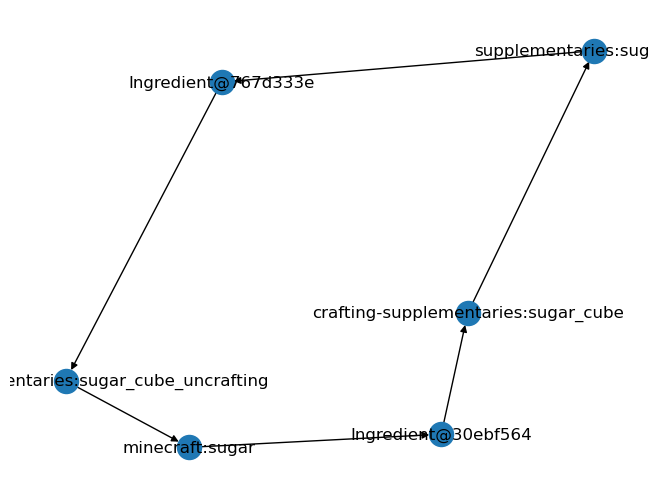

In [78]:
subgraph.nodes["crafting-minecraft:sugar_from_sugar_cane"]["SCT"] = 1
subgraph.nodes["create:milling-create:milling/sugar_cane"]["SCT"] = 2
subgraph.nodes["crafting-minecraft:sugar_from_honey_bottle"]["SCT"] = 5
print(subgraph.nodes["cycle-0"]["subgraph"])
nx.draw(subgraph.nodes["cycle-0"]["subgraph"], pos=nx.spring_layout(subgraph.nodes["cycle-0"]["subgraph"]), arrows=True, with_labels=True)
plt.show()

In [79]:
def initCycle(G : nx.DiGraph, cycleNode):
    for n in G.nodes[cycleNode]["subgraph"].nodes:
        inputs = getInputNodes(subgraph, cycleNode, n)
        if len(inputs) == 0:
            continue
        computeValueCycle(G, cycleNode, n, inputs)

def getInputNodes(G : nx.DiGraph, cycleNode, n):
    inputs = {}
    for p in G.predecessors(cycleNode):
        if n in G[p][cycleNode]["to_subnode"]:
            inputs[p] = G[p][cycleNode]["weight"][G[p][cycleNode]["to_subnode"].index(n)]
    return inputs

def computeValueCycle(G : nx.DiGraph, cycleNode, node, inputNodes : dict):
    t = G.nodes[cycleNode]["subgraph"].nodes[node]["type"]

    if t == "item":
        computeValueItemCycle(G, cycleNode, node, inputNodes)
    if t == "ingredient":
        computeValueIngredientCycle(G, cycleNode, node, inputNodes)
    if t == "craft":
        computeValueRecipeCycle(G, cycleNode, node, inputNodes)

def computeValueItemCycle(G : nx.DiGraph, cycleNode, node, inputNodes : dict):
    # Only Recipes nodes connect to an Item node
    # The logic is x = rk / ck
    G.nodes[cycleNode]["subgraph"].nodes[node]["SCT"] = [G.nodes[p]["SCT"] / inputNodes[p] for p in inputNodes]
    G.nodes[cycleNode]["subgraph"].nodes[node]["SCT"] = np.nanmin(G.nodes[cycleNode]["subgraph"].nodes[node]["SCT"])

def computeValueIngredientCycle(G : nx.DiGraph, cycleNode, node, inputNodes : dict):
    # Only Item nodes connect to an Ingredient node
    # The logic is X = min(xi)
    G.nodes[cycleNode]["subgraph"].nodes[node]["SCT"] = [G.nodes[p]["SCT"] for p in inputNodes]
    G.nodes[cycleNode]["subgraph"].nodes[node]["SCT"] = np.nanmin(G.nodes[cycleNode]["subgraph"].nodes[node]["SCT"])

def computeValueRecipeCycle(G : nx.DiGraph, cycleNode, node, inputNodes : dict):
    # Only Ingredient nodes connect to a Craft node
    # The logic is r = sum(Xi * ci)
    G.nodes[cycleNode]["subgraph"].nodes[node]["SCT"] = [G.nodes[p]["SCT"] * inputNodes[p] for p in inputNodes]
    G.nodes[cycleNode]["subgraph"].nodes[node]["SCT"] = np.nansum(G.nodes[cycleNode]["subgraph"].nodes[node]["SCT"])

In [80]:
for n, data in subgraph.nodes["cycle-0"]["subgraph"].nodes.data():
    print(n, data)
initCycle(subgraph, "cycle-0")
print()
for n, data in subgraph.nodes["cycle-0"]["subgraph"].nodes.data():
    print(n, data)

Ingredient@767d333e {'type': 'ingredient', 'SCT': nan, 'color': 'orange', 'size': 5, 'shape': 'square'}
supplementaries:sugar_cube {'type': 'item', 'SCT': nan, 'color': '#8ceef5', 'size': 30, 'shape': 'dot'}
crafting-supplementaries:sugar_cube_uncrafting {'type': 'craft', 'SCT': nan, 'color': 'green', 'size': 15, 'shape': 'diamond'}
minecraft:sugar {'type': 'item', 'SCT': nan, 'color': '#8ceef5', 'size': 30, 'shape': 'dot'}
Ingredient@30ebf564 {'type': 'ingredient', 'SCT': nan, 'color': 'orange', 'size': 5, 'shape': 'square'}
crafting-supplementaries:sugar_cube {'type': 'craft', 'SCT': nan, 'color': 'green', 'size': 15, 'shape': 'diamond'}

Ingredient@767d333e {'type': 'ingredient', 'SCT': nan, 'color': 'orange', 'size': 5, 'shape': 'square'}
supplementaries:sugar_cube {'type': 'item', 'SCT': nan, 'color': '#8ceef5', 'size': 30, 'shape': 'dot'}
crafting-supplementaries:sugar_cube_uncrafting {'type': 'craft', 'SCT': nan, 'color': 'green', 'size': 15, 'shape': 'diamond'}
minecraft:sugar 

In [84]:
test_cycle = subgraph.nodes["cycle-0"]["subgraph"].copy()
for n, data in test_cycle.nodes.data():
    computeValue(test_cycle, n)

print("-"*30)
for n, data in test_cycle.nodes.data():
    print(n, data["SCT"])

Computing node Ingredient@767d333e
Has predecessors ['supplementaries:sugar_cube'] [nan]
Computing node supplementaries:sugar_cube
Has predecessors ['crafting-supplementaries:sugar_cube'] [nan]
Computing node crafting-supplementaries:sugar_cube
Has predecessors ['Ingredient@30ebf564'] [nan]
Computing node Ingredient@30ebf564
Has predecessors ['minecraft:sugar'] [np.float64(1.0)]
	 Ingredient node Ingredient@30ebf564 has values [np.float64(1.0)] -> 1.0
	 Craft node crafting-supplementaries:sugar_cube has value 9.0
	 Item node supplementaries:sugar_cube has values [np.float64(9.0)] -> 9.0
	 Ingredient node Ingredient@767d333e has values [np.float64(9.0)] -> 9.0
Computing node supplementaries:sugar_cube
Has predecessors ['crafting-supplementaries:sugar_cube'] [np.float64(9.0)]
	 Item node supplementaries:sugar_cube has values [np.float64(9.0)] -> 9.0
Computing node crafting-supplementaries:sugar_cube_uncrafting
Has predecessors ['Ingredient@767d333e'] [np.float64(9.0)]
	 Craft node crafti

In [13]:
import numpy as np

test = np.array([1,4,2,1])
print(test)
test = set([float(i) for i in test])
print(test)

[1 4 2 1]
{1.0, 2.0, 4.0}


# Verifications

## Does every item in an in ingredient share the same amount used?

In [4]:
for r in recipes.keys():
    for ingr in recipes[r]["input"].keys():
        count = np.nan
        for i,n in recipes[r]["input"][ingr].items():
            if np.isnan(count):
                count = n
            if count != n:
                print(r,ingr,i)


## Is every ingredient name unique?

In [12]:
ingrlist = {}
amountlist = {}
for r in recipes.keys():
    for ingr in recipes[r]["input"].keys():
        if ingr in ingrlist.keys():
            if set(ingrlist[ingr]) != set(recipes[r]["input"][ingr].keys()) or set(amountlist[ingr]) != set(recipes[r]["input"][ingr].values()):
                print(f"Duplicate ingredient for recipe {r} : {ingr}")
                print("-"*30)
                print(ingrlist[ingr])
                print(amountlist[ingr])
                print(recipes[r]["input"][ingr])
                print("\n")
        ingrlist[ingr] = list(recipes[r]["input"][ingr].keys())
        amountlist[ingr] = list(recipes[r]["input"][ingr].values())

Duplicate ingredient for recipe protection_pixel:bloodprisonerloot : Ingredient@62859c60
------------------------------
['minecraft:iron_ingot']
[2]
{'minecraft:iron_ingot': 4}


Duplicate ingredient for recipe create:cutting/runtime_generated/compat/minecraft/warped_planks_to_warped_slab : Ingredient@c82ad4c2
------------------------------
['minecraft:warped_planks']
[3]
{'minecraft:warped_planks': 1}


Duplicate ingredient for recipe minecraft:mangrove_fence : Ingredient@c6bccad3
------------------------------
['minecraft:mangrove_planks']
[1]
{'minecraft:mangrove_planks': 4}


Duplicate ingredient for recipe create:crafting/kinetics/nozzle : Ingredient@34f0725d
------------------------------
['create:andesite_alloy']
[3]
{'create:andesite_alloy': 4}


Duplicate ingredient for recipe minecraft:iron_sword : Ingredient@26682724
------------------------------
['minecraft:stick']
[2]
{'minecraft:stick': 1}


Duplicate ingredient for recipe minecraft:loom : Ingredient@6006e1ad
-----------

## How are double cycles managed?

{'ice', 'I-P', 'blue', 'B-P', 'P-I', 'packed', 'P-B'}


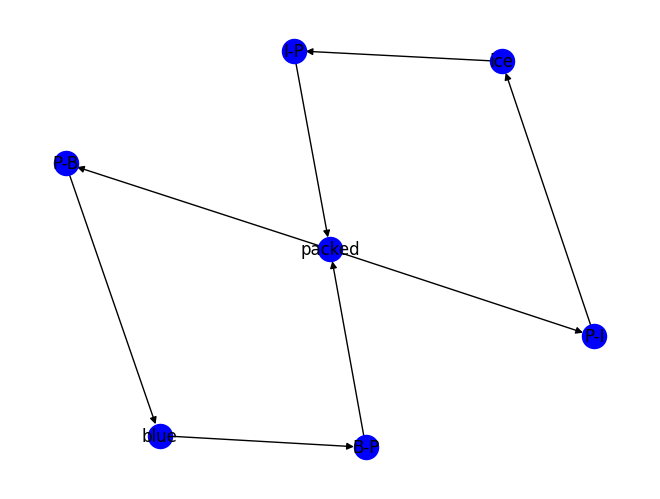

In [17]:
test = nx.DiGraph()

test.add_nodes_from(["ice","packed","blue","I-P","P-I","P-B","B-P"])
test.add_edges_from([["ice","I-P"],["I-P","packed"],["packed","P-I"],["P-I","ice"],["packed","P-B"],["P-B","blue"],["blue","B-P"],["B-P","packed"]])

nx.draw(test, pos=nx.spring_layout(test), with_labels=True, node_color="blue")

for cycle in nx.strongly_connected_components(test):
    print(cycle)

## Can a single item output to multiple ingredients

In [28]:
for n,data in graph.nodes.data():
    if data["type"] == "item":
        childs = set(nx.neighbors(graph, n))
        if len(childs) > 1:
            print(n, childs)

create:small_granite_bricks {'Ingredient@a77e4304', 'Ingredient@916200e8'}
minecraft:red_wool {'Ingredient@d613120a', 'Ingredient@fc552418', 'Ingredient@3b57dd8', 'Ingredient@605e0053', 'Ingredient@13194db7', 'Ingredient@17f89140', 'Ingredient@8c76d8', 'Ingredient@ed219c3d', 'Ingredient@244755a9', 'Ingredient@d4b935d6', 'Ingredient@2e2f5470', 'Ingredient@710378da', 'Ingredient@e4b11603', 'Ingredient@614da5da', 'Ingredient@482c3ab5', 'Ingredient@e9fdcfa', 'Ingredient@be6201f1'}
l2artifacts:pirate_body_5 {'Ingredient@e8e6ce05', 'Ingredient@fa37c515'}
l2artifacts:pirate_body_4 {'Ingredient@fa37c514', 'Ingredient@e8e6ce05', 'Ingredient@f1524a32'}
l2artifacts:pirate_body_3 {'Ingredient@91524554', 'Ingredient@e8e6ce05', 'Ingredient@fa37c513'}
l2artifacts:pirate_body_2 {'Ingredient@fa37c512', 'Ingredient@e8e6ce05', 'Ingredient@5e0cd784'}
l2artifacts:saint_necklace_4 {'Ingredient@fa37c514', 'Ingredient@e8e6ce05', 'Ingredient@4d818369'}
l2artifacts:saint_necklace_5 {'Ingredient@e8e6ce05', 'Ingr